In [1]:
# 在本机未更新至2.0.8的情况下，使用vnpy2.0.8的回测逻辑
import sys
import os
from pathlib import Path
new_version_path = Path(os.getenv('VNPY2.0.8'))
sys.path.insert(0, str(new_version_path))

import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

from datetime import datetime
from research_backtest import get_hot_start, run_research_backtest, batch_run, analyze_multi_bt, str_to_params, params_to_str
from utility import get_output_folder, get_output_path

2.0.8


#### 多品种回测测试

Custom Note编号：

- Entry: En
- Exit: Ex
- Stop: St
- Filter: Fi

例子
- En-Fi-ma(20,0.02)
- St-Atr(3)

#### 单品种回测及成交记录分析

In [ ]:
commodity = 'FG'
start = get_hot_start(commodity)
end = datetime(2019, 12, 1)
params_dict = {
    'entry_window': 50,
    'exit_window': 25
#     'stop_multiple': 4
}

res_dict = run_research_backtest(commodity, start, end, trade_output=True, curve_output=True, strategy_params=params_dict)
res_dict


params_str = params_to_str(params_dict)
filename = f'turtle.{commodity}.{params_str}.default.trades.csv'
trades = pd.read_csv(get_output_path(filename, 'trades'))
cum_pnl = 0
for idx, trade in trades.iterrows():
    print(f"{trade.vt_symbol} \t {trade.datetime} \t {trade.direction} \t {trade.price}")
    if trade.offset == "open":
        entry = trade.price
        volume = 1 if trade.direction == "long" else -1
    
    if trade.offset == "close":
        pnl = (trade.price - entry) * volume
        cum_pnl += pnl
        print(f"Trade Pnl: {pnl} \t Cum Pnl: {cum_pnl}")
        print("=" * 60)
        print("\n")

### 统计多品种回测结果

In [2]:
folder = get_output_folder('multi_backtest')
files = list(folder.glob('*.csv'))

res_list = []
columns = []
for file in files:
    res = analyze_multi_bt(file.name)
    res_list.append(res)
    columns = list(res.keys())

df = pd.DataFrame(res_list, columns=columns)
df['note'] = df['test_name'].map(lambda x: x.split('@')[-1])

# 添加参数列，用于筛选
note = 'inv_trade'
df = df[df['note'] == note]

params_dict_list = [str_to_params(name.split('@')[1]) for name in df['test_name']]
params_df = pd.DataFrame(params_dict_list, index=df.index)
df = pd.concat([df, params_df], axis=1)

df

# show_items = ['annual_mean', 'all_invest', 'sharpe_mean', 'max_dd', 'win_mean', 'win_to_loss']
# pivoted = df.pivot('exit_window', 'stop_multiple', show_items)
# pivoted = df.pivot('entry_window', 'exit_window', show_items)

# pivoted['sharpe_mean']

,test_name,all_invest,daily_trade,win,loss,win_rate,annual_mean,max_dd,best_rtn,worst_rtn,best_ddp,worst_ddp,sharpe_mean,win_mean,win_to_loss,cost_ratio,note,entry_window,exit_window
140,turtle_inverse@entry_window_50.exit_window_10@...,10049,12.958755,16,21,0.432432,-1.212894,-25.506110,37.296296,-99.339286,-3.780342,-105.115223,-0.082670,0.601166,0.612929,0.0,inv_trade,50.0,10.0
141,turtle_inverse@entry_window_50.exit_window_15@...,8347,10.769378,17,20,0.459459,-1.172289,-26.404550,27.000000,-102.290076,-4.861945,-109.177570,-0.057973,0.601960,0.614976,0.0,inv_trade,50.0,15.0
142,turtle_inverse@entry_window_50.exit_window_20@...,7267,9.372917,16,21,0.432432,-1.212347,-26.381890,27.925926,-83.863636,-5.563255,-92.803624,-0.066943,0.602709,0.610916,0.0,inv_trade,50.0,20.0
143,turtle_inverse@entry_window_50.exit_window_25@...,6497,8.347079,17,20,0.459459,-1.203858,-26.859205,21.666667,-82.108586,-4.230143,-94.479524,-0.057973,0.605227,0.609534,0.0,inv_trade,50.0,25.0
144,turtle_inverse@entry_window_50.exit_window_30@...,5883,7.519315,18,19,0.486486,-1.115649,-27.174143,36.778455,-87.881679,-6.103286,-100.781386,-0.043965,0.607537,0.615245,0.0,inv_trade,50.0,30.0
145,turtle_inverse@entry_window_50.exit_window_35@...,5388,6.912376,21,16,0.567568,-0.839267,-27.073729,36.514228,-83.732143,-6.389059,-91.543304,-0.028163,0.608616,0.624897,0.0,inv_trade,50.0,35.0
146,turtle_inverse@entry_window_50.exit_window_40@...,4982,6.377553,18,19,0.486486,-0.842879,-28.506463,35.162602,-88.660714,-6.977887,-94.899170,-0.022416,0.616098,0.606418,0.0,inv_trade,50.0,40.0
147,turtle_inverse@entry_window_50.exit_window_45@...,4576,5.874391,18,19,0.486486,-0.964799,-30.610763,27.544776,-97.714286,-6.863158,-103.865146,-0.015100,0.622346,0.587813,0.0,inv_trade,50.0,45.0
148,turtle_inverse@entry_window_50.exit_window_50@...,4197,5.389403,17,20,0.459459,-1.047247,-30.269095,25.522388,-85.714286,-6.825749,-93.227495,-0.037316,0.622554,0.580659,0.0,inv_trade,50.0,50.0


#### 双变量概览

In [ ]:
# 展示热力图
%matplotlib notebook
plt.rcParams.update({'font.size': 8})
import seaborn as sns

show_items = ['annual_mean', 'all_invest', 'sharpe_mean', 'max_dd', 'win_mean', 'win_to_loss']

plt.figure(figsize=(10, 12))

annual_plot = plt.subplot(3, 2, 1)
annual_plot.set_title("Annual Return Mean")
sns.heatmap(pivoted['annual_mean'], fmt='d', linewidths=.5, cmap='YlGnBu')

invest_plot = plt.subplot(3, 2, 2)
invest_plot.set_title('Invest count')
sns.heatmap(pivoted['all_invest'], fmt='d', linewidths=.5, cmap='YlGnBu')

sharpe = plt.subplot(3, 2, 3)
sharpe.set_title('Sharpe Ratio Mean')
sns.heatmap(pivoted['sharpe_mean'], fmt='d', linewidths=.5, cmap='YlGnBu')

drawdown_plot = plt.subplot(3, 2, 4)
drawdown_plot.set_title('Max drawdown percent Mean')
sns.heatmap(pivoted['max_dd'], fmt='d', linewidths=.5, cmap='YlGnBu')

win_plot = plt.subplot(3, 2, 5)
win_plot.set_title('Winning rate Mean')
sns.heatmap(pivoted['win_mean'], fmt='d', linewidths=.5, cmap='YlGnBu')

win_to_loss_plot = plt.subplot(3, 2, 6)
win_to_loss_plot.set_title('Win to loss mean ')
sns.heatmap(pivoted['win_to_loss'], fmt='d', linewidths=.5, cmap='YlGnBu')

plt.tight_layout(pad=4) 

#### 单变量分析

In [3]:
df_single = df.copy()

fixed_var = 'entry_window'
fixed_var_value = 50
analyze_var = 'exit_window'

df_single = df_single[df_single[fixed_var] == fixed_var_value]
df_single.set_index(analyze_var, inplace=True)

# df_single = df_single[df_single['stop_multiple'] == 4]
# df_single.set_index('exit_window', inplace=True)

df_single.sort_index(inplace=True)
# df_single

<IPython.core.display.Javascript object>


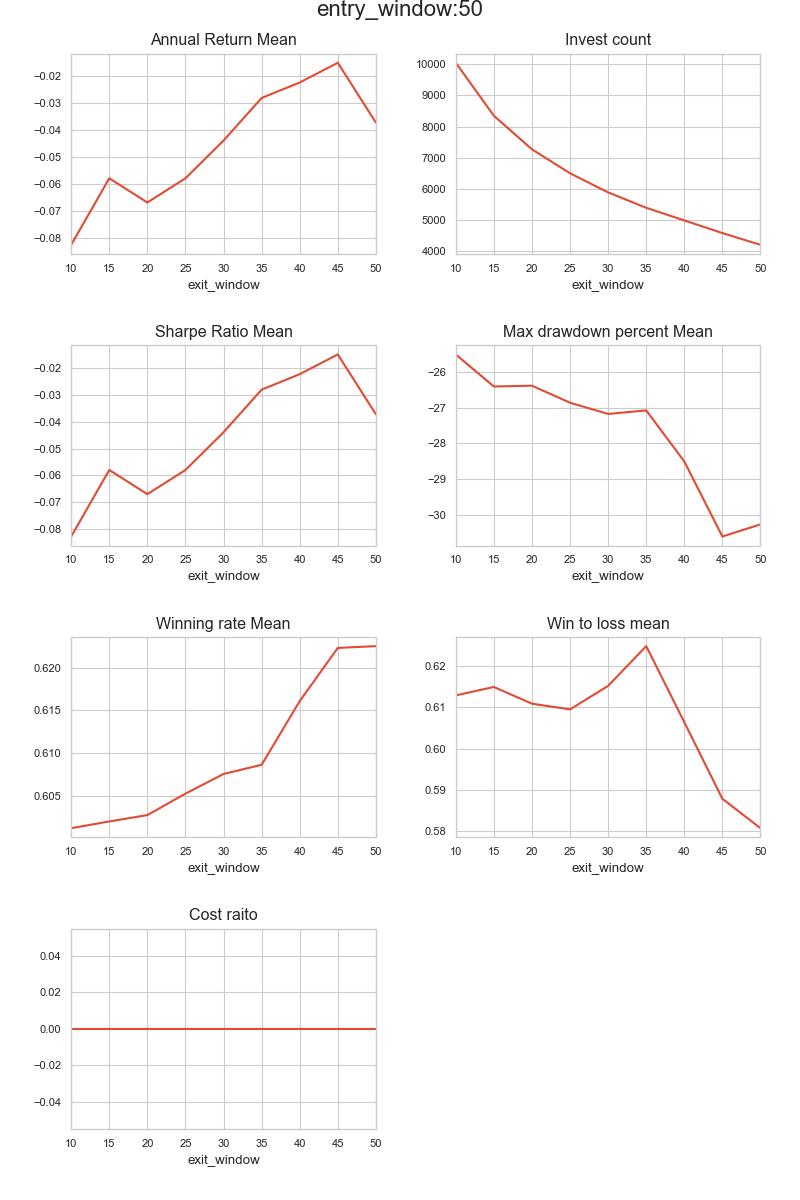

In [4]:
%matplotlib notebook
plt.rcParams.update({'font.size': 8})
fig = plt.figure(figsize=(8, 12))
fig.suptitle(f'{fixed_var}:{fixed_var_value}', fontsize=16, y=1)

annual_plot = plt.subplot(4, 2, 1)
annual_plot.set_title("Annual Return Mean")
df_single['sharpe_mean'].plot()

invest_plot = plt.subplot(4, 2, 2)
invest_plot.set_title('Invest count')
df_single['all_invest'].plot()

sharpe = plt.subplot(4, 2, 3)
sharpe.set_title('Sharpe Ratio Mean')
df_single['sharpe_mean'].plot()

drawdown_plot = plt.subplot(4, 2, 4)
drawdown_plot.set_title('Max drawdown percent Mean')
df_single['max_dd'].plot()

win_plot = plt.subplot(4, 2, 5)
win_plot.set_title('Winning rate Mean')
df_single['win_mean'].plot()

win_to_loss_plot = plt.subplot(4, 2, 6)
win_to_loss_plot.set_title('Win to loss mean')
df_single['win_to_loss'].plot()

cost_ratio_plot = plt.subplot(4, 2, 7)
cost_ratio_plot.set_title('Cost raito')
df_single['cost_ratio'].plot()

plt.tight_layout(pad=3)


In [ ]:
# 分析单结果
filename = 'turtle_default_St-Atr(5).csv'

res = analyze_multi_bt(filename)
res

In [ ]:
# multiprocessing test
from multiprocessing import Pool
def test(i):
    print(i ** 2)
    
pool = Pool(processes=4)
for i  in range(500):
    pool.apply_async(test, args=(i,)) #维持执行的进程总数为10，当一个进程执行完后启动一个新进程.       
print('test')
pool.close()
pool.join()